#Install cellworld library, import relevant packages, set global variables

In [39]:
%%capture
%pip install json_cpp==1.0.61
%pip install cellworld==0.0.359

In [40]:
import pandas as pd
from google.colab import drive
from cellworld import *
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from statistics import mean
import math
import numpy as np
from json_cpp import *
from matplotlib import cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

In [62]:
world = World.get_from_parameters_names("hexagonal", "canonical", "030_12_0063")
cell_size = world.implementation.cell_transformation.size


In [42]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Select Data

In [43]:
# cellworld methods paper data
directory_path = 'drive/MyDrive/MacIver Lab: Habitat/Data/PEEK' # official experiments
experiment_list = os.listdir(directory_path)
print(f"Experiments: {experiment_list}")



Experiments: ['PEEK_20221107_1046_FMM9_00_00_CT1', 'PEEK_20221107_1137_MMM10_00_00_CT1', 'PEEK_20221107_1358_FMM10_00_00_CT1', 'PEEK_20221107_1444_MMM11_00_00_CT1', 'PEEK_20221114_1015_MMM10_21_05_RT1', 'PEEK_20221114_1114_FMM10_21_05_HT4', 'PEEK_20221114_1523_FMM9_21_05_HT4', 'PEEK_20221114_1431_MMM11_21_05_HT5', 'PEEK_20221111_1559_MMM11_21_05_HT4', 'PEEK_20221115_0949_FMM10_21_05_HT5', 'PEEK_20221115_1038_MMM11_21_05_HT5', 'PEEK_20221115_1339_FMM9_21_05_HT5', 'PEEK_20221115_1450_MMM10_21_05_RT2', 'PEEK_20221116_1022_MMM11_21_05_RT1', 'PEEK_20221116_1114_FMM9_21_05_HT6', 'PEEK_20221116_1337_MMM10_21_05_RT3', 'PEEK_20221116_1429_FMM10_21_05_HT6', 'PEEK_20221117_1028_FMM9_21_05_HT7', 'PEEK_20221117_1122_MMM10_21_05_RT4', 'PEEK_20221117_1249_FMM10_21_05_HT7', 'PEEK_20221117_1412_MMM11_21_05_RT2', 'PEEK_20221118_1114_MMM10_21_05_RT5', 'PEEK_20221118_1204_FMM10_21_05_HT8', 'PEEK_20221118_1631_FMM9_21_05_HT8', 'PEEK_20221121_1332_MMM10_21_05_RT6', 'PEEK_20221117_1359_MMM11_21_05_RT2', 'PEE

In [53]:
# new data
directory_path = 'drive/MyDrive/MacIver Lab: Habitat/Data/PEEK03' # official experiments
experiment_list = os.listdir(directory_path)
print(f"Experiments: {experiment_list}")


Experiments: ['PEEK03_20231109_1357_MMM20_030_01_0092_HT1', 'PEEK03_20231109_1439_FMM20_030_01_0092_HT1', 'PEEK03_20231109_1540_MMM18_030_12_0063_HT1', 'PEEK03_20231110_1016_MMM20_030_01_0092_HT2', 'PEEK03_20231110_1058_FMM20_030_01_0092_HT2', 'PEEK03_20231110_1324_MMM18_030_12_0063_HT2', 'PEEK03_20231110_1414_FMM19_030_12_0063_HT1', 'PEEK03_20231127_1555_FMM19_030_12_0063_HT2', 'PEEK03_20231128_1139_MMM18_030_12_0063_RT1', 'PEEK03_20231129_1042_FMM19_030_12_0063_HT4', 'PEEK03_20231129_1127_MMM20_030_01_0092_HT5']


In [54]:
experiment_index = experiment_list.index('PEEK03_20231128_1139_MMM18_030_12_0063_RT1')  # select experiment
experiment = experiment_list[experiment_index]
print(f"Experiment selected: {experiment}")

experiment_path = directory_path + "/" + experiment
episode_list = [item for item in os.listdir(experiment_path) if item.startswith('episode_')]
print(f"Episodes: {episode_list}")

Experiment selected: PEEK03_20231128_1139_MMM18_030_12_0063_RT1
Episodes: ['episode_022', 'episode_006', 'episode_021', 'episode_016', 'episode_002', 'episode_012', 'episode_015', 'episode_014', 'episode_001', 'episode_000', 'episode_018', 'episode_013', 'episode_007', 'episode_017', 'episode_008', 'episode_011', 'episode_004', 'episode_020', 'episode_009', 'episode_003', 'episode_010', 'episode_005', 'episode_019']


In [55]:
df = pd.DataFrame(columns=['experiment', 'episode',
                           'prey_location', 'predator_location',
                           'prey_velocity', 'predator_velocity',
                           'prey_stop_frames', 'predator_stop_frames',
                           'prey_frames', 'predator_frames', 'predator_state'])

# loop through experiment episodes and grab information from the trajectory object
for episode_number in episode_list:
  episode = experiment + "_" + episode_number
  occlusions = "21_05"    # specify world
  file_path = directory_path + '/' + experiment + '/' + episode_number + '/' + episode + '.json'

  trajectory_object = Episode.load_from_file(file_path).trajectories.split_by_agent()
  prey_trajectory = trajectory_object['prey']
  predator_trajectory = trajectory_object ['predator']

  # locations
  prey_location = prey_trajectory.get('location').to_numpy_array()
  predator_location = predator_trajectory.get('location').to_numpy_array()

  # velocity
  prey_velocity = prey_trajectory.get_velocities()["prey"]
  predator_velocity = predator_trajectory.get_velocities()["predator"]

  # stop frames
  prey_stop_frames = prey_trajectory.get_stops()            # get frames
  predator_stop_frames = predator_trajectory.get_stops()
  prey_trajectory_frames = prey_trajectory.get("frame")
  predator_trajectory_frames = predator_trajectory.get("frame")


  # add data to df
  temp_df = pd.DataFrame({'experiment': [experiment], 'episode': [episode_number],
                          'prey_location': [prey_location], 'predator_location': [predator_location],
                          'prey_velocity': [prey_velocity], 'predator_velocity': [predator_velocity],
                          'prey_stop_frames': [prey_stop_frames],'predator_stop_frames': [predator_stop_frames],
                          'prey_frames' : [prey_trajectory_frames], 'predator_frames': [predator_trajectory_frames]})
  df = pd.concat([df, temp_df], ignore_index=True)



In [56]:
def convert_to_indices(row, frames_column, stop_frames_column):
    return [(row[frames_column].index(start), row[frames_column].index(stop)) for start, stop in row[stop_frames_column]]

def filter_velocity(row, velocity_column):
  """
  Converts velocity to cm/s and filters it
  """
  velocity_data = [2.34 * 100 * i for i in row[velocity_column]]
  return Velocities(velocity_data).moving_average_filter(15)

def get_moving_velocities(row, filtered_velocity_column, stop_indices_column):
  def remove_sections(lst, sections):
    for start_index, end_index in sorted(sections, reverse=True):
        del lst[start_index:end_index+1]
    return lst

  moving_vels = remove_sections(row[filtered_velocity_column].copy(), row[stop_indices_column])
  return moving_vels



# add step indices of stop interval
df['prey_stop_indices'] = df.apply(lambda row: convert_to_indices(row, 'prey_frames', 'prey_stop_frames'), axis=1)
df['predator_stop_indices'] = df.apply(lambda row: convert_to_indices(row, 'predator_frames', 'predator_stop_frames'), axis=1)

# filter velocity columns
df['filtered_prey_velocity'] = df.apply(lambda row: filter_velocity(row, 'prey_velocity'), axis=1)
df['filtered_predator_velocity'] = df.apply(lambda row: filter_velocity(row, 'predator_velocity'), axis=1)

# moving speed (filtered and in cm/s)
df['moving_prey_velocity'] = df.apply(lambda row: get_moving_velocities(row, 'filtered_prey_velocity', 'prey_stop_indices'), axis=1)
df['moving_predator_velocity'] = df.apply(lambda row: get_moving_velocities(row, 'filtered_predator_velocity', 'predator_stop_indices'), axis=1)

# average moving speed (cm/s)
df['avg_moving_prey_velocity'] = df['moving_prey_velocity'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
df['avg_moving_predator_velocity'] = df['moving_predator_velocity'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

# max speed (cm/s)
df['max_predator_speed'] = df['filtered_predator_velocity'].apply(max)


df.set_index('episode', inplace=True)  # Set 'episode' as the index for better use with .loc

# Find the speed ratio between the agents
Average speed ratios for the specified epsiode and experiment, respectively.

In [57]:
# select episode
specified_episode = df['max_predator_speed'].idxmax()

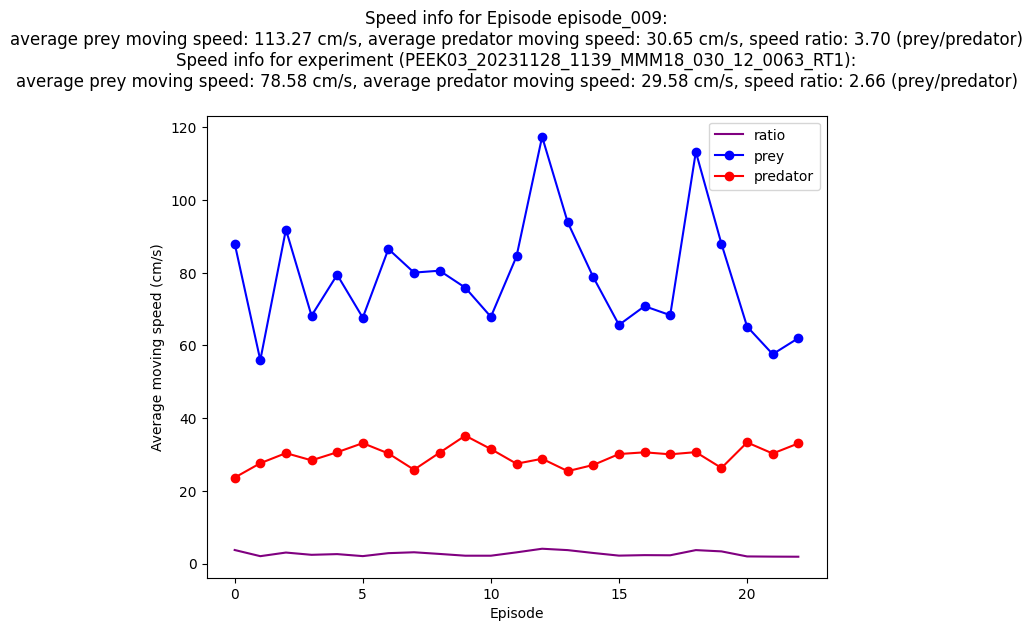

In [59]:
# get average moving speed values for specified episode
a = df.loc[specified_episode, 'avg_moving_prey_velocity']
b = df.loc[specified_episode, 'avg_moving_predator_velocity']
episode_text = f"Speed info for Episode {specified_episode}:\naverage prey moving speed: {a:.2f} cm/s, average predator moving speed: {b:.2f} cm/s, speed ratio: {a/b:.2f} (prey/predator)"

# Get average moving speed values for the specified experiment
a = df['avg_moving_prey_velocity'].mean()
b = df['avg_moving_predator_velocity'].mean()
experiment_text = f"\nSpeed info for experiment ({experiment}):\naverage prey moving speed: {a:.2f} cm/s, average predator moving speed: {b:.2f} cm/s, speed ratio: {a/b:.2f} (prey/predator)\n"

# Plot speed ratio
df['avg_velocity_ratio'] = df['avg_moving_prey_velocity'] / df['avg_moving_predator_velocity']
plt.figure(figsize=(8, 6))
plt.plot(df['avg_velocity_ratio'].values, color='purple', label='ratio')
plt.plot(df['avg_moving_prey_velocity'].values, color='blue', label='prey', marker='o')
plt.plot(df['avg_moving_predator_velocity'].values, color='red', label='predator', marker='o')
plt.xlabel('Episode')
plt.ylabel('Average moving speed (cm/s)')
plt.legend()

# Set the title with the printed text
plt.title(f"{episode_text}{experiment_text}")
plt.show()



# Robot speed metrics
Here the results for the robot speed are presented using a variety of metrics.

Robot Specifications: The speed metric used for the robot is tick count per 7.5 ms. There are 1040 tick counts per revolution.

Summary: speed command units: tick count / 7.5 ms | tick count per wheel revolution: 1040 ticks / revolution | wheel diameter: 0.039 meters

In [60]:
def embeddedSpeed_to_standardizedUnits(embeddedSpeed, wheel_radius = 0.039/2):
  """
  Covert robot speed from ticks per 7.5 ms (units of spped message sent to robot) to meters/second
  Input:
  embeddedSpeed (ticks/75ms)
  wheel_radius (meters)
  """
  angular_velocity = (embeddedSpeed/7.5) * ((2 * math.pi * 1000)/ 1040) # rads/s
  print(f"Speed: {angular_velocity * wheel_radius: .2f} m/s")


# get max values for experiment
speed = df['max_predator_speed'].max()/100
wheel_radius = 0.039/2 # meters
angular_velocity = speed / wheel_radius # rads/s
rpm = angular_velocity * (60/(2* math.pi))
ticks_per_ms = rpm * (1040/60000)
tick_per_7p5ms = ticks_per_ms * 7.5

# print speed information
print(f"Max robot speed info for {experiment}:")
print(f"Max Robot Speed: {tick_per_7p5ms: .2f} ticks per 7.5ms, {rpm: .2f} rev/sec, {speed :.2} m/s, {speed * 100 } cm/s")  # robot speed metric
# embeddedSpeed_to_standardizedUnits(60, wheel_radius = 0.039/2)

Max robot speed info for PEEK03_20231128_1139_MMM18_030_12_0063_RT1:
Max Robot Speed:  40.51 ticks per 7.5ms,  311.65 rev/sec, 0.64 m/s, 63.63926041283252 cm/s


# Plot the trajectory of both agents for a specified episode

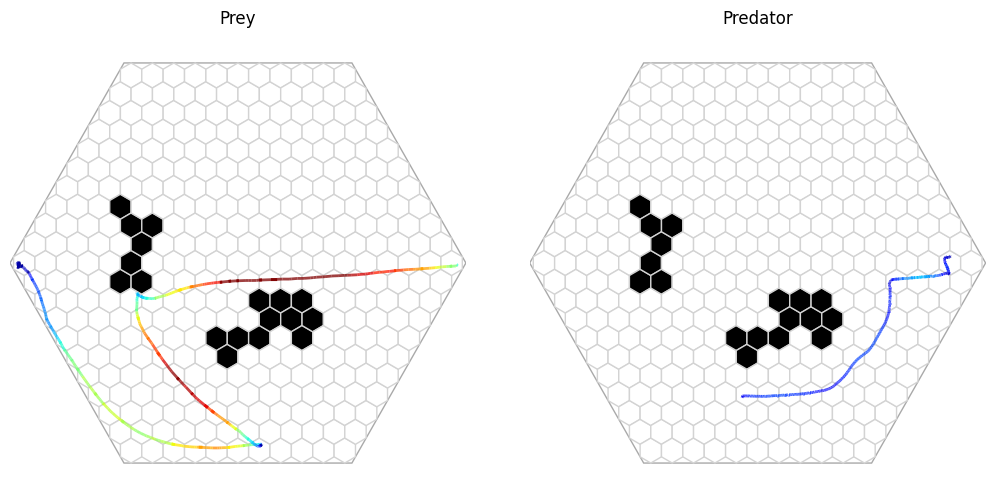

<Figure size 1000x1000 with 0 Axes>

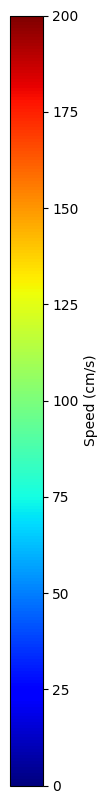

In [63]:
# Create a grid with a common colorbar
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.1])  # 3 columns, with the last one reserved for the colorbar

# Subplots
axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]
d1 = Display(world, padding=0, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="darkgrey", ax=axs[0])
d2 = Display(world, padding=0, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="darkgrey", ax=axs[1])

# Common colorbar for both plots
cax = plt.subplot(gs[2])

# Common colormap and normalization
cmap_common = cm.jet
norm_common = plt.Normalize(0, 200)

def plot_trajectory(ax, locations, velocity, label):
    x, y = locations.T
    segments = np.column_stack([x, y]).reshape(len(x), 1, 2)
    points = np.array([x, y]).T.reshape(len(x), 1, 2)
    segments = np.concatenate([segments[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap_common, norm=norm_common, linewidth=2, alpha=0.75)
    lc.set_array(velocity)
    ax.add_collection(lc)
    ax.set_title(label)
    ax.axis('off')


# Plot prey trajectory
plot_trajectory(axs[0], df.loc[specified_episode, "prey_location"], df.loc[specified_episode, "filtered_prey_velocity"], 'Prey')

# # Plot predator trajectory
plot_trajectory(axs[1], df.loc[specified_episode, "predator_location"], df.loc[specified_episode, "filtered_predator_velocity"], 'Predator')

# # Common colorbar for both plots
sm_common = plt.cm.ScalarMappable(cmap=cmap_common, norm=norm_common)
sm_common.set_array([])
cbar_common = plt.colorbar(sm_common, cax=cax, label='Speed (cm/s)')

plt.show()